# Project 2：NASA Data Acquisation, Visualization, and Analysis

In [32]:
# The code makes sure that once there is change in the 'src/' folder, the 
# change will be automatically reloaded in the notebook.
%reload_ext autoreload
%autoreload 2
%aimport src

### Task 1: Understanding the NASA API and Data Collection

- Register for a NASA API key and understand the different types of data that the API provides.
- Run the Python script below to fetch data about **Near Earth Objects (NEOs)** from the NASA API for a years data.
- Extract and understand the different pieces of data provided for each NEO.

In [38]:
import requests
import time
from datetime import datetime, timedelta
from getpass import getpass

# Set your NASA API KEY, this step asks you to enter your API KEY.
# (The input box may be float in the top on your editor.)
#J9ZCigzcPv62cDxGx0g4qyzRe1V8sVeVDsQlKLbf
api_key = getpass()

In [39]:
# Set the start and end dates for the data you want to fetch
start_date = datetime.strptime('2022-01-01', '%Y-%m-%d')
end_date = start_date + timedelta(days=365)  # 1 year later

# Initialize a list to store the data
data = []

# Fetch data from the NASA API 7 days at a time
# The introduction of the API is on https://api.nasa.gov, under "Browse APIs" -> "Asteroids NeoWs"
# You can look into the example query in the link below to see what the data look like:
# https://api.nasa.gov/neo/rest/v1/feed?start_date=2015-09-07&end_date=2015-09-08&api_key=DEMO_KEY
current_date = start_date
while current_date < end_date:
    next_date = min(current_date + timedelta(days=7), end_date)
    response = requests.get(f'https://api.nasa.gov/neo/rest/v1/feed?start_date={current_date.strftime("%Y-%m-%d")}&end_date={next_date.strftime("%Y-%m-%d")}&api_key={api_key}')
    data.append(response.json())
    current_date = next_date
    time.sleep(1)  # To avoid hitting the rate limit

# Now 'data' contains the NEO data for the 1-year period


In [40]:
# Check the date coverage of your data.
dates_contained_in_data = []
for d in data:
    if 'near_earth_objects' in d:
        dates_contained_in_data += list(d['near_earth_objects'].keys())

print(sorted(dates_contained_in_data))

['2022-01-01', '2022-01-02', '2022-01-03', '2022-01-04', '2022-01-05', '2022-01-06', '2022-01-07', '2022-01-08', '2022-01-08', '2022-01-09', '2022-01-10', '2022-01-11', '2022-01-12', '2022-01-13', '2022-01-14', '2022-01-15', '2022-01-15', '2022-01-16', '2022-01-17', '2022-01-18', '2022-01-19', '2022-01-20', '2022-01-21', '2022-01-22', '2022-01-22', '2022-01-23', '2022-01-24', '2022-01-25', '2022-01-26', '2022-01-27', '2022-01-28', '2022-01-29', '2022-01-29', '2022-01-30', '2022-01-31', '2022-02-01', '2022-02-02', '2022-02-03', '2022-02-04', '2022-02-05', '2022-02-05', '2022-02-06', '2022-02-07', '2022-02-08', '2022-02-09', '2022-02-10', '2022-02-11', '2022-02-12', '2022-02-12', '2022-02-13', '2022-02-14', '2022-02-15', '2022-02-16', '2022-02-17', '2022-02-18', '2022-02-19', '2022-02-19', '2022-02-20', '2022-02-21', '2022-02-22', '2022-02-23', '2022-02-24', '2022-02-25', '2022-02-26', '2022-02-26', '2022-02-27', '2022-02-28', '2022-03-01', '2022-03-02', '2022-03-03', '2022-03-04', '2022

In [69]:
from src.utils import get_a_random_chunk_property

In [70]:
get_a_random_chunk_property(data)

date: 2022-02-15
NEO name: (2021 SU1)
nasa_jpl_url: http://ssd.jpl.nasa.gov/sbdb.cgi?sstr=54200305


For the remaining tasks, you have to organize the data as pd.DataFrame so as to suit the specific need in each task. This part may require a considerably amount of efforts, which is normal in data science and analytics works.

### Task 2: Data Analysis

- Calculate the average size of the NEOs for each day.
- Determine the proportion of NEOs that are potentially hazardous.
- Find the NEO with the closest approach distance for each day.
- Use statistical methods to analyze the data. For example, calculate the mean, median, mode, and standard deviation of the NEO sizes. Determine if the size of a NEO is correlated with whether it is potentially hazardous.

In [183]:
from collections import defaultdict
import pandas as pd

neo_data = []
daily_neo_sizes = defaultdict(list)

neo_data = []
for d in data:
    if 'near_earth_objects' in d:
        for date in d['near_earth_objects']:
            for neo in d['near_earth_objects'][date]:
                estimated_diameter = neo.get('estimated_diameter', {}).get('kilometers', {})
                diameter_max = estimated_diameter.get('estimated_diameter_max')
                diameter_min = estimated_diameter.get('estimated_diameter_min')
                average_size = round((diameter_max + diameter_min) / 2 * 1000, 2)  # Convert to meters and round to 2 decimals

                neo_entry = {
                    'date': date,
                    'name': neo['name'],
                    'size': round(diameter_max, 2),
                    'hazardous': neo['is_potentially_hazardous_asteroid'],
                    'approach_distance': neo['close_approach_data'][0]['miss_distance']['kilometers'],
                    'relative_velocity': round(float(neo['close_approach_data'][0]['relative_velocity']['kilometers_per_hour']), 2),  # Convert to float
                    'average_size in meters': average_size  # Renamed column to 'average_size in meters'
                }
                neo_data.append(neo_entry)
                daily_neo_sizes[date].append(neo['estimated_diameter']['kilometers']['estimated_diameter_max'])

df = pd.DataFrame(neo_data)

df['approach_distance'] = pd.to_numeric(df['approach_distance'])

# Calculate the danger level based on the specified criteria
df['danger_level'] = round(df['average_size in meters'] * df['relative_velocity'] * (1 / df['approach_distance']) * 10**2, 2)

# Calculate average size of NEOs for each day
average_neo_sizes = {}
for date, sizes in daily_neo_sizes.items():
    average_size = sum(sizes) / len(sizes)
    average_neo_sizes[date] = average_size

# Print average size of NEOs for each day
for date, average_size in average_neo_sizes.items():
    print(f"Date: {date}, Average Size: {average_size}")

Date: 2022-01-07, Average Size: 0.18852323585555553
Date: 2022-01-08, Average Size: 0.26108220680000005
Date: 2022-01-03, Average Size: 0.03894232270714287
Date: 2022-01-04, Average Size: 0.1108051283111111
Date: 2022-01-05, Average Size: 0.24481385145999998
Date: 2022-01-06, Average Size: 0.26676748642000014
Date: 2022-01-01, Average Size: 0.22673848123043477
Date: 2022-01-02, Average Size: 0.15655437684615384
Date: 2022-01-09, Average Size: 0.12759933872
Date: 2022-01-14, Average Size: 0.37832721182352946
Date: 2022-01-15, Average Size: 0.13071276665555553
Date: 2022-01-10, Average Size: 0.17940406500666664
Date: 2022-01-11, Average Size: 0.12657713819000002
Date: 2022-01-12, Average Size: 0.14115104221428573
Date: 2022-01-13, Average Size: 0.189119858945
Date: 2022-01-18, Average Size: 0.28527608466875
Date: 2022-01-19, Average Size: 0.14061264883
Date: 2022-01-16, Average Size: 0.15446125585
Date: 2022-01-17, Average Size: 0.34853153554166655
Date: 2022-01-21, Average Size: 0.27937

In [96]:
total_neos = 0  # Variable to store the total number of NEOs
hazardous_neos = 0  # Variable to store the number of hazardous NEOs

# Iterate over the data to count the number of NEOs and hazardous NEOs
for d in data:
    if 'near_earth_objects' in d:  # Check if 'near_earth_objects' key is present
        for date in d['near_earth_objects']:  # Iterate over the dates
            for neo in d['near_earth_objects'][date]:  # Iterate over the NEOs
                total_neos += 1  # Increment the total number of NEOs
                if neo['is_potentially_hazardous_asteroid']:  # Check if NEO is hazardous
                    hazardous_neos += 1  # Increment the number of hazardous NEOs

proportion_hazardous = hazardous_neos / total_neos  # Calculate the proportion of hazardous NEOs

# Print the proportion of hazardous NEOs
print(f"Proportion of hazardous NEOs: {proportion_hazardous:.2%}")

Proportion of hazardous NEOs: 6.38%


In [97]:
closest_neos = {}  # Dictionary to store the NEO with closest approach distance for each day

# Iterate over the data to find the NEO with closest approach distance for each day
for d in data:
    if 'near_earth_objects' in d:  # Check if 'near_earth_objects' key is present
        for date in d['near_earth_objects']:  # Iterate over the dates
            closest_distance = float('inf')  # Set the initial closest distance to infinity
            closest_neo = None  # Variable to store the closest NEO
            for neo in d['near_earth_objects'][date]:  # Iterate over the NEOs
                approach_distance = float(neo['close_approach_data'][0]['miss_distance']['kilometers'])  # Get the approach distance
                if approach_distance < closest_distance:  # Check if the approach distance is closer
                    closest_distance = approach_distance  # Update the closest distance
                    closest_neo = neo  # Update the closest NEO
            closest_neos[date] = closest_neo  # Store the closest NEO for the day in the dictionary

# Print the NEO with the closest approach distance for each day
for date, neo in closest_neos.items():
    print(f"Date: {date}, Closest NEO: {neo['name']}, Approach Distance: {neo['close_approach_data'][0]['miss_distance']['kilometers']} kilometers")

Date: 2022-01-07, Closest NEO: (2022 AR2), Approach Distance: 645892.648390259 kilometers
Date: 2022-01-08, Closest NEO: (2022 AE5), Approach Distance: 2964655.504489047 kilometers
Date: 2022-01-03, Closest NEO: (2022 AU), Approach Distance: 318517.890647922 kilometers
Date: 2022-01-04, Closest NEO: (2022 AT1), Approach Distance: 2041258.537972622 kilometers
Date: 2022-01-05, Closest NEO: (2022 AV13), Approach Distance: 109480.269041248 kilometers
Date: 2022-01-06, Closest NEO: (2022 AY4), Approach Distance: 302040.732452512 kilometers
Date: 2022-01-01, Closest NEO: (2022 AJ1), Approach Distance: 770529.455550131 kilometers
Date: 2022-01-02, Closest NEO: (2022 AP1), Approach Distance: 180597.061908216 kilometers
Date: 2022-01-09, Closest NEO: (2022 AE2), Approach Distance: 1775451.337140904 kilometers
Date: 2022-01-14, Closest NEO: (2022 AA4), Approach Distance: 1392857.29786012 kilometers
Date: 2022-01-15, Closest NEO: (2022 AT2), Approach Distance: 727675.574910996 kilometers
Date: 2

In [107]:
import numpy as np

# Convert neo_data list to a pandas DataFrame
df = pd.DataFrame(neo_data)  # Creating a DataFrame from the neo_data list

# Calculate mean, median, mode, and standard deviation of NEO sizes
mean_size = df['size'].mean()
median_size = df['size'].median()
mode_size = df['size'].mode().values[0]
std_dev_size = df['size'].std()

# Print data
print(f"Mean NEO Size: {mean_size:.2f} kilometers")
print(f"Median NEO Size: {median_size:.2f} kilometers")
print(f"Mode NEO Size: {mode_size:.2f} kilometers")
print(f"Standard Deviation of NEO Sizes: {std_dev_size:.2f} kilometers")

# Determine correlation between NEO size and hazardous status
correlation = df['size'].corr(df['hazardous'])

#Print correlation
print(f"Correlation between NEO Size and Hazardous Status: {correlation:.2f}")

Mean NEO Size: 0.21 kilometers
Median NEO Size: 0.08 kilometers
Mode NEO Size: 0.02 kilometers
Standard Deviation of NEO Sizes: 0.41 kilometers
Correlation between NEO Size and Hazardous Status: 0.26


### Task 3: Data Visualization Part A

- Create a line plot of the number of NEOs per week.
- Create a histogram of the distribution of NEO sizes.
- Create a bar plot of the average NEO size per week.
- Use a library like Seaborn to create more complex visualizations, such as a box plot of the NEO sizes or a heat map of the number of NEOs per week. **Be creative**!

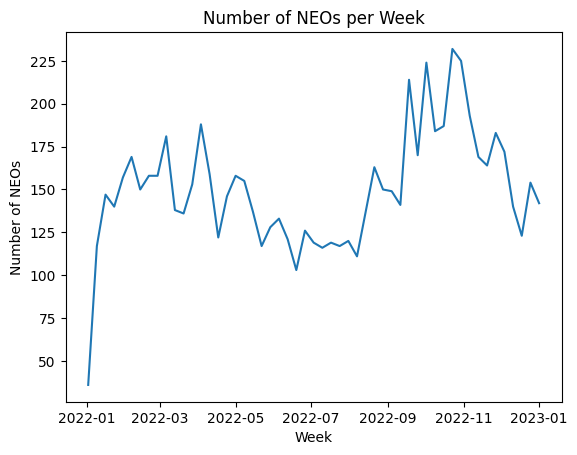

In [164]:
import matplotlib.pyplot as plt

# Load the dataset into a DataFrame
df = pd.DataFrame(neo_data)  # Creating a DataFrame from the neo_data list
df['date'] = pd.to_datetime(df['date'])  # Converting the 'date' column to datetime format
df.set_index('date', inplace=True)  # Setting the 'date' column as the index of the DataFrame

# Resample the data to calculate the number of NEOs per week
weekly_neo_count = df.resample('W').size()

# Plot the number of NEOs per week
plt.plot(weekly_neo_count)

# Set the plot title and labels
plt.title('Number of NEOs per Week')
plt.xlabel('Week')
plt.ylabel('Number of NEOs')

# Show the plot
plt.show()

The graph shows the develpment in the amount of NEOs during the year. The amount of newly discovered near-Earth objects (NEOs) is lowest in June/July and highest during the early November period. The first datapoint is the lowest, but it looks like a mistake or just a starting point.

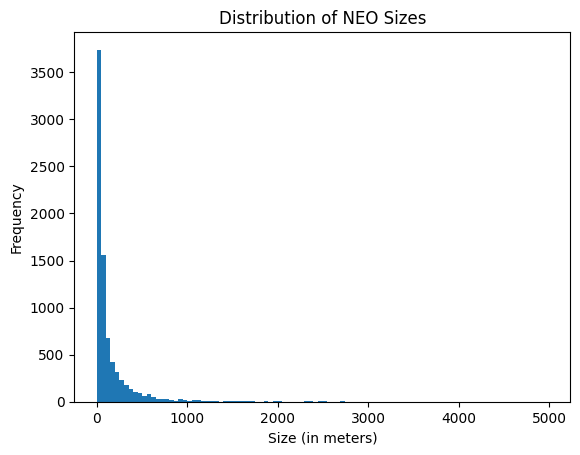

In [169]:
# Load the dataset into a DataFrame
df = pd.DataFrame(neo_data)  # Creating a DataFrame from the neo_data list
neo_sizes = df['average_size in meters']  # Extracting the 'average_size in meters' column from the DataFrame

# Plot the histogram of NEO sizes
plt.hist(neo_sizes, bins=100)

# Set the plot title and labels
plt.title('Distribution of NEO Sizes')
plt.xlabel('Size (in meters)')
plt.ylabel('Frequency')

# Show the plot
plt.show()

The histogram plot suggest that most NEO (Near-Earth Object) sizes are smaller, with a larger concentration of sizes below 0.5 kilometers and especially at 0.1 kilometers. This indicates that there are more NEOs with smaller sizes compared to larger sizes.

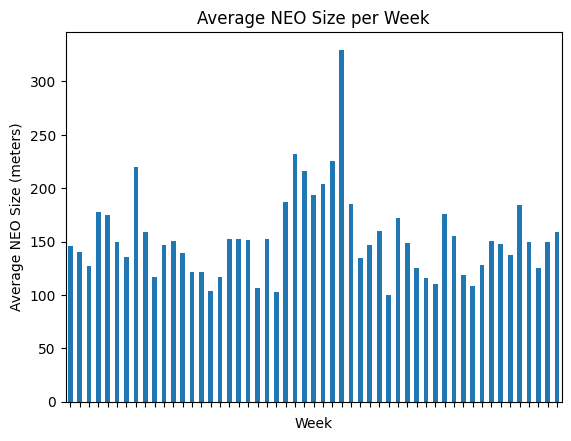

In [170]:
# Load the dataset into a DataFrame
df = pd.DataFrame(neo_data)  # Creating a DataFrame from the neo_data list
df['date'] = pd.to_datetime(df['date'])  # Converting the 'date' column to datetime format
df.set_index('date', inplace=True)  # Setting the 'date' column as the index of the DataFrame

# Resample the data to calculate the average NEO size per week
weekly_neo_average = df.resample('W')['average_size in meters'].mean()

# Plot the bar plot of average NEO size per week
ax = weekly_neo_average.plot(kind='bar')

# Set the plot title and labels
plt.title('Average NEO Size per Week')
plt.xlabel('Week')
plt.ylabel('Average NEO Size (meters)')

# Remove x-axis tick labels
ax.set_xticklabels([])

# Show the plot
plt.show()

Based on the bar plot, it can be observed that the largest average NEO size is a little over 0.4 kilometers. For most weeks the average is about 0.2km, which makes sense considering the earlier histogram.

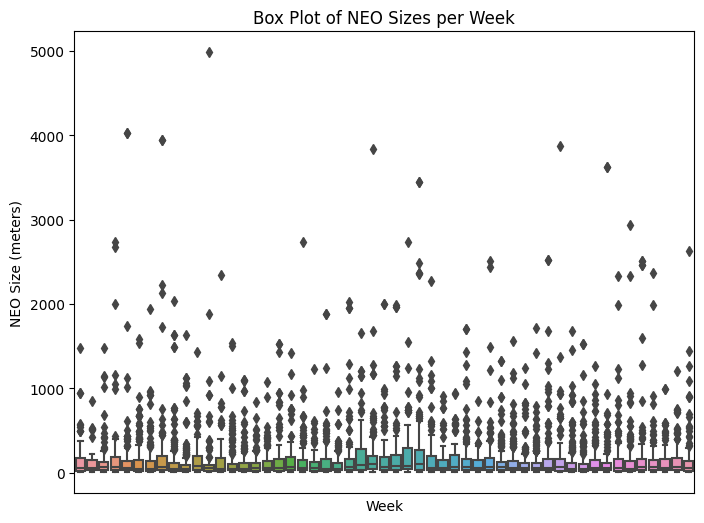

In [173]:
import seaborn as sns

# Load the dataset into a DataFrame
df = pd.DataFrame(neo_data)  # Creating a DataFrame from the neo_data list
df['date'] = pd.to_datetime(df['date'])  # Converting the 'date' column to datetime format
df.set_index('date', inplace=True)  # Setting the 'date' column as the index of the DataFrame

# Box plot of NEO sizes
plt.figure(figsize=(8, 6))  # Creating a new figure with the specified size
ax = sns.boxplot(x=df.index.to_period('W').astype(str), y='average_size in meters', data=df)  # Creating a box plot of NEO sizes per week

# Set the plot title and labels
plt.title('Box Plot of NEO Sizes per Week')
plt.xlabel('Week')
plt.ylabel('NEO Size (meters)')

# Remove x-axis ticks and labels
ax.set_xticks([])
ax.set_xticklabels([])

# Show the plot
plt.show()

Comparing the interquartile ranges and whiskers(the box lengths) of the box plots shows that the data is concentrated and that most NEOs are 0.1-0.3 km. However, almost all the weeks have outliers about 0.5km.

In [174]:
## Interpreting the violin plot:

# The violin plot will have two sections, one for each hazardous category (True and False).
# The width of the violins represents the density of data points at different NEO sizes.
# The vertical extent of the violins indicates the distribution of NEO sizes. Wider sections represent a higher density of NEOs with those sizes.
# The box plot inside each violin provides additional information about quartiles, median, and outliers.
# You can hover over the violins to see the names of individual NEOs.
# By examining the violin plot, you can compare the distributions of NEO sizes between hazardous and non-hazardous categories and identify any differences or patterns.


import plotly.express as px

# Create a violin plot
fig = px.violin(df, x='hazardous', y='average_size in meters', color='hazardous',
                box=True, points='all', hover_data=['name'],
                labels={'average_size in meters': 'NEO Size (in meters)', 'hazardous': 'Hazardous'})

# Customize the appearance of the violin plot
fig.update_traces(meanline_visible=True, line_color='black')

# Set the title and axis labels
fig.update_layout(title='Distribution of NEO Size by Hazardous Category',
                  xaxis_title='Hazardous',
                  yaxis_title='NEO Size (meters)')

# Show the plot
fig.show()

The violin plot shows the concentration of different sizes for hazardous and and non-hazardous NEOs. Non-hazardous NEOs are often smaller than the hazardous NEOs, but can also be bigger than the hazardous NEOs. The hazardous NEOs are consentrated around 0.2-0.3, where the non-hazardous are concentrated around 0.05-0.1

In [179]:
import plotly.graph_objects as go

df = pd.DataFrame(neo_data)  # Creating a DataFrame from the neo_data list
df['date'] = pd.to_datetime(df['date'])
df['week_number'] = df['date'].dt.isocalendar().week

# Filter the data to include only size up to 2
filtered_data = df[df['size'] <= 2]

# Group the filtered data by week number and size, and calculate the count of NEOs
heatmap_data = filtered_data.groupby(['week_number', 'size']).size().unstack(fill_value=0)

# Create the heatmap using Plotly
fig = go.Figure(data=go.Heatmap(
    z=heatmap_data.values,
    x=heatmap_data.columns,
    y=heatmap_data.index,
    colorscale='YlGnBu',
))

# Customize the layout of the heatmap
fig.update_layout(
    title='Number of NEOs per Week - Heatmap',
    xaxis_title='Size',
    yaxis_title='Week Number',
)

# Set the x-axis range to limit up to size=2
fig.update_xaxes(range=[0, 2])

# Show the heatmap
fig.show()

The heatmap plot uses color to show the density of NEOs in different weeks. This indicates which weeks have higher NEO counts and is a more detailed plot than the lineplot.

### Task 4: Data Visualization Part B

- Create a pie chart of the proportion of hazardous vs non-hazardous NEOs.
- Create a scatter plot of the correlation between NEO size and close approach distance.
- Customize the appearance of your plots (e.g., colors, labels, titles).
- Create interactive visualizations using a library like Plotly. For example, create an interactive scatter plot where you can hover over each point to see more information about the NEO. **Be creative!**

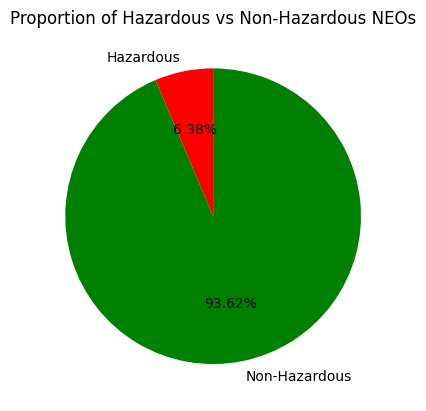

In [180]:
# Pie chart of the proportion of hazardous VS non-hazardous NEOs:
hazardous_count = df['hazardous'].sum()
non_hazardous_count = len(df) - hazardous_count

labels = ['Hazardous', 'Non-Hazardous']  # Labels for the pie chart
values = [hazardous_count, non_hazardous_count]  # Values corresponding to each label

# Define the colors for hazardous and non-hazardous slices
colors = ['red', 'green']

# Plot the pie chart with custom colors
plt.pie(values, labels=labels, autopct='%1.2f%%', startangle=90, colors=colors)
# Creating a pie chart with the provided values and labels
# The autopct parameter formats the percentage values with two decimal place
# The startangle parameter rotates the pie chart to start at the specified angle
# The colors parameter sets the custom colors for each slice

# Set the plot title
plt.title('Proportion of Hazardous vs Non-Hazardous NEOs')

# Show the plot
plt.show()

The graph shows that most of the NEOs are non-hazardous and only 6.38% are hazardous

In [186]:
# This plot tells a lot about the dangers of the NEOs.
# y axis: NEOs size 
# x axis: Approach distance
# Marker color: Hazardous: Red - Not hazardous: Green
# Marker size: Danger level. - The danger level is the product of size, approach distance and relative velocity.

import plotly.express as px
import numpy as np

# Define marker size based on the danger_level column
marker_size = df['danger_level']

# Set the desired minimum and maximum marker sizes
marker_min_size = 200
marker_max_size = 40

# Adjust marker size to ensure it is above the minimum size
marker_size = np.maximum(marker_size, marker_min_size)

# Create a scatter plot using Plotly Express
fig = px.scatter(df, y='average_size in meters', x='approach_distance', color='hazardous', hover_data=['name', 'relative_velocity'],
                 labels={'average_size in meters': 'NEO Size (in meters)', 'approach_distance': 'Close Approach Distance (in kilometers)'},
                 title='Correlation between NEO Size and Close Approach Distance',
                 template='plotly_white',
                 size=marker_size,
                 size_max=marker_max_size,
                 color_discrete_map={True: 'red', False: 'green'})

# Add custom hover template
fig.update_traces(hovertemplate='<b>NEO Name:</b> %{customdata[0]}<br><b>NEO Size:</b> %{y} km<br><b>Close Approach Distance:</b> %{x} km<br><b>Relative Velocity:</b> %{customdata[1]} km/s')

# Set the height & width of the plot window
fig.update_layout(height=700, width=1200)

# Show the interactive plot
fig.show()

The scatterplot shows the NEO sizes and the approach distance. The sizes of the dots shows the danger level of the NEOs, calculated earlier. It is seen that most of the hazardous NEOs have a close aprroach distance. However, most of them aren't that dangerous, except for the big, red dot, which we should be aware of.

In [187]:
import plotly.graph_objects as go

# Filter the DataFrame to include only hazardous NEOs
hazardous_df = df[df['hazardous']]

# Create the 3D scatter plot using Plotly
fig = go.Figure(data=go.Scatter3d(
    x=hazardous_df['size'],
    y=hazardous_df['approach_distance'],
    z=hazardous_df['relative_velocity'],
    mode='markers',  # Display points as markers
    marker=dict(
        size=2,  # Set the marker size
        color='red', # Set the color
        opacity=0.2  # Set the marker opacity
    )
))

# Customize the layout of the 3D scatter plot
fig.update_layout(
    scene=dict(
        xaxis_title='NEO Size (in kilometers)',
        yaxis_title='Approach Distance (in kilometers)',
        zaxis_title='Relative Velocity (in kilometers per hour)',
    ),
    title='3D Scatter Plot of Hazardous NEOs',
)

# Display the plot
fig.show()

The 3D scatter plot visualizes the relationship between NEO-size, approach distance, and relative velocity for the hazardous NEOs, which are 3 different parameters for how hazardous the NEO is. The most hazardous NEO would be high in relative velocity and size and small i distance. However, as most hazardous NEOs are pretty small, it would mostly depend on the two other categories and the corner they create, where we see a few NEOs. Luckily, most NEOs arent in that corner, as also seen above, and therefore aren't that hazardous.

In [213]:
import plotly.express as px

# Filter the DataFrame to include only hazardous entries and danger levels <= 3000
filtered_df = df[(df['hazardous']) & (df['danger_level'] <= 3000)]

# Create a scatter plot using Plotly Express
fig = px.scatter(filtered_df, x='relative_velocity', y='danger_level', color='average_size in meters',
                 color_continuous_scale='Viridis',  # Specify the color scale
                 opacity=1.0,  # Set marker opacity to 1.0 (fully opaque)
                 labels={'relative_velocity': 'Relative Velocity', 'danger_level': 'Danger Level'},
                 title='Scatter Plot of NEO Danger Level and Relative Velocity (Hazardous Only, <= 3000)',
                 template='plotly_white')

# Set the height & width of the plot window
fig.update_layout(height=500, width=800)

# Show the colorbar indicating the average size
fig.update_coloraxes(colorbar_title='Size')

# Show the plot
fig.show()

The plot shows the correlation between danger level and relative velocity and the color shows the size (it is important to note, that danger level is calcultated with relative velocity and that we have removed one datapoint at (7000,70000) for better visualisation). It is seen that most of the dangerous NEOs have a smaller relative velocity, which is opposite of what we expected

In [188]:
## Trying a 2D histogram, again not getting the desired result..

import plotly.graph_objects as go

fig = go.Figure(data=go.Histogram2d(
    x=df['average_size in meters'],  # Replace 'average_size in meters' with the desired attribute from your dataset
    y=df['approach_distance'],  # Replace 'approach_distance' with another attribute if desired
    colorscale='Plasma',  # Choose a colorscale for the heatmap
    colorbar=dict(
        title='Count',  # Set the title for the colorbar
    ),
))

fig.update_layout(
    title='2D Histogram of NEOs',  # Set the title of the plot
    xaxis_title='NEO Size (in meter)',  # Set the x-axis label
    yaxis_title='Approach Distance (in kilometers)',  # Set the y-axis label
)

fig.show()

This plot visualizes the relationship between the NEO size and approach distance. The histogram is represented as a heatmap using the 'Plasma' colorscale. The plot includes a colorbar showing the count. You can't see much from this data.

In [189]:
import plotly.graph_objects as go

# Apply logarithmic transformation to the data
normalized_size = np.log10(df['average_size in meters'])
normalized_approach_distance = np.log10(df['approach_distance'])

# Create a 2D histogram using Plotly
fig = go.Figure(data=go.Histogram2d(
    x=normalized_size,
    y=normalized_approach_distance,
    colorscale='Plasma',  # Choose a colorscale for the heatmap
    colorbar=dict(
        title='Count',  # Set the title for the colorbar
    ),
))

fig.update_layout(
    title='2D Histogram of NEOs',
    xaxis_title='Logarithm of NEO Size',
    yaxis_title='Logarithm of Approach Distance',
)

fig.show()

This plot is using the same data as the above 2D histogram, with one important exception: we have used a logarithmic function to emphasize the data, resulting in more color, making it easier to see “medium range” data. This makes it a little easier to analyse the data

In [190]:
## Doing a bar chart of the NEOs, not very informative i think.

import plotly.graph_objects as go

# Convert the 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'])

# Calculate the count of NEOs per week
weekly_counts = df['date'].dt.isocalendar().week.value_counts().sort_index()

# Calculate the count of hazardous and non-hazardous NEOs per week
hazardous_counts = df[df['hazardous']].groupby(df['date'].dt.isocalendar().week).size().sort_index()
non_hazardous_counts = df[~df['hazardous']].groupby(df['date'].dt.isocalendar().week).size().sort_index()

# Create the bar chart for the count of NEOs per week
fig = go.Figure()
#fig.add_trace(go.Bar(
    #x=weekly_counts.index,
    #y=weekly_counts.values,
    #name='NEOs',
    #marker_color='lightblue',
#))

# Create the stacked bar chart for the count of hazardous and non-hazardous NEOs per week
fig.add_trace(go.Bar(
    x=hazardous_counts.index,
    y=hazardous_counts.values,
    name='Hazardous',
    marker_color='red',
))
fig.add_trace(go.Bar(
    x=non_hazardous_counts.index,
    y=non_hazardous_counts.values,
    name='Non-Hazardous',
    marker_color='green',
))

# Customize the layout of the combination plot
fig.update_layout(
    title='Frequency of NEOs and Hazard Level',
    xaxis_title='Week',
    yaxis_title='Count',
    barmode='stack',
)

fig.show()

This plot illustrates the number of hazardous and non-hazardous NEOs every week of the year. It has a hover function that shows week number and NEO count for that given week.

In [191]:
## This is a 3D scatter plot showing only the dangerous NEOs.
#  Dot color is the danger level, the danger level is calculated as a product of 3 factors: Size, Relative velocity and Passing distance.
#  Also a dangerous NEO counter has been added.

import plotly.graph_objects as go

# Filter the dataframe to include only hazardous NEOs
hazardous_df = df[df['hazardous']]

# Calculate the overall count of hazardous NEOs
hazardous_count = len(hazardous_df)

# Create the scatter plot
fig = go.Figure(data=go.Scatter(
    x=hazardous_df['date'],
    y=hazardous_df['average_size in meters'],
    mode='markers',
    marker=dict(
        size=8,
        color=hazardous_df['danger_level'],
        colorscale='Reds',
        colorbar=dict(title='Danger Level'),
        line=dict(width=1, color='black')
    ),
    hovertext=hazardous_df['name'].values,
    hovertemplate='<b>Name: %{hovertext}</b><br><br>'
                  'average_size in meters: %{y}<br>'
                  'Date: %{x}<br>'
                  'Danger Level: %{marker.color}<br>'
))

# Set the layout of the plot
fig.update_layout(
    title='Hazardous NEOs',
    xaxis=dict(
        title='Timeline',
        range=['2021-12-20', '2023-01-10']  # Range to adjust the x-axis
    ),
    yaxis=dict(title='Size'),
    showlegend=False
)

# Set the height & width of the plot window
fig.update_layout(height=700, width=1200)

# Add a text annotation for the hazardous count
fig.add_annotation(
    x='2022-02-01',  # Example x-coordinate for the annotation
    y=4.1,
    text=f'Hazardous Count: {hazardous_count}',
    showarrow=False,
    font=dict(size=12)
)

# Show the plot
fig.show()

This 3D scatterplot displays a lot of different information:
It gives you information about whether or not a NEO is considered hazardous (By color) and also supplies info on NEO size and earth proximity. The marker size indicates the danger level of the NEO. -This is calculated as a function of NEO size, proximity, and relative velocity.
It also features a hover function with the following data: Name, size, proximity and relative velocity.

### Task 5: Interpretation of Results

- Interpret the results of your data visualization in part A and B. 
- What insights can you gain about NEOs from your results? Summarizing your findings.
- Use your findings to make predictions or recommendations. For example, if you found that larger NEOs are more likely to be potentially hazardous, you could recommend that more resources be allocated to tracking large NEOs. **Be creative!**
- Identify, understand, and explain one scientific paper, on a clustering or classification method of relevance that could help Task 5. You don't have to implement it, you just need to justify in this notebook why the method in the scientific paper could contribute in analysis or interpretation of the results.

In the beginning of the assignment we made a new variable, Danger level, which is the combination of Size, Speed and Distance to Earth. We did this based on our own expectations for what would affect the danger level and the available data. We then used this variable to determine which NEOs are the most dangerous.
Our dataanalysis shows that there are about 150-200 NEOs pr week, but only a small amount of these are actually hazardous. Most of the NEOs are pretty small in size, but can be relatively big, up to 5km i diameter. Most of the hazardous NEOs are about 200-300 meters i diameter and aren't that hazardous, but have been observed up to 3km i diameter during the year. It can also be observed that the most hazardous NEOs have a close approach distance, especially for a distance under 10m km. For over 25m km, there isn't a big difference in the amount of hazardous NEOs or how hazardous they are. In the graph for relative velocity it can be seen that there aren't that many hazardous NEOs with a high relative velocity, which is opposite of what we expectet. This might have something to do with the composition of the NEOs, which affect how hazardous they are, or how easy they are to redirect.
We have also observed that there are more NEOs in Oktober and November, but as we only have data from one year, we don't know if there is a similar distribution for other years of if it is random. It could make sense to look at data from other years, to see if the pattern is the same, so you know what time of year to focus. As mentioned above, most dangerous NEOs are 200-300 meters in diameter, so perhaps more resources should be used on tracking that specific size. It would also be wise to focus more on tracking NEOs with a close approach to the Earth, as these are often more hazardous.
We have found a scientific paper that explains the Torino Impact Hazard scale, which is a simple and effective tool to convey the level of concern and urgency for close encounters. The scale combines collision probability and estimated kinetic energy to assign a value from 0 to 10, with higher values indicating greater probability and more severe consequences. If we had had the data for collision probability and kinetic energy, we could have made a better Danger level variable which would actually be supported by scientific data instead of assuming what would affect the danger level. This would give more precise analysis of the NEOs and would make our recomendations even better.


https://www.sciencedirect.com/science/article/abs/pii/S0032063300000064

### Task 6: Presentation and Documentation

- Make this project as part of your presentation, **using beamer in LaTeX**. 
- This should include an overview of your work, the results of your data analysis, and the insights you gained from your results.